# Algoithmic Fairness, Accountability and Ethics
## Assignment 2 (Template)

In [278]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [279]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

## Task 1

In [280]:
######
## YOUR CODE
#####

## Task 2

### Convert categorical to one-hot encoding

In [281]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features_raw, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P
features_raw.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [282]:
# Drop the "redundant" columns
features = features_raw.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [283]:
from sklearn.model_selection import train_test_split

In [321]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, labels, groups, test_size=0.3, random_state=0, shuffle=True)

N = 5000 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

### Build your own implementation of the Logistic Regression with L2-penalty (aka Ridge Regression).

In [336]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import sklearn
import pandas as pd

def sigmoid(x, eps=1e-10):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1 / (1 + np.exp(-x-eps))


def logistic_loss(y_true, y_pred, eps=1e-10):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    return np.mean(
        -y_true * np.log(y_pred+eps) - (1 - y_true) * np.log(1 - y_pred+eps)
    )


def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.sum(beta[1:]**2)


def group_fair_loss(y, y_pred, all_groups):
    """
    Group fairness Loss
    """
    fairness = 0
    for groups in all_groups.T:
        y, y_pred, groups = [
            pd.Series(np.squeeze(data), name=name)
            for name, data in [("y", y), ("y_pred", y_pred), ("groups", groups)]
        ]
        X_groups = pd.concat([y, y_pred], axis=1).groupby(groups)
        X_g1, X_g2 = X_groups.get_group(1), X_groups.get_group(2)

        cross_pairs = X_g1.merge(X_g2, how="cross", suffixes=["1", "2"])
        assert len(cross_pairs) == len(X_g1) * len(X_g2)

        df = cross_pairs
        fairness += np.mean((df["y1"] == df["y2"]) * (df["y_pred1"] - df["y_pred2"])**2)
    return fairness


def compute_gradient(beta, X, y, groups, _lambda, _gamma):
    """Calculate the gradient - used for finding the best beta values.
    You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    y_pred = predict(X, beta)

    grad = 1/len(y) * ((y_pred - y) @ X)
    grad[1:] += 2 * _gamma * beta[1:]
    assert grad.shape == beta.shape, "gradient shape doesnt match beta shape"
    return grad


def compute_cost(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = predict(X, beta)

    loss = logistic_loss(y, y_pred) + _gamma*l2_loss(beta) # + _lambda*group_fair_loss(y, y_pred, groups)
    return loss


def predict(X, beta):
    return sigmoid(X @ beta)

class LogReg(BaseEstimator):
    def __init__(self, gamma, lambda_):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.scaler = StandardScaler().set_output(transform='pandas')

    def _add_bias(self, X_train):
        bias = pd.Series(np.ones_like(X_train[X_train.columns[0]]), name="bias", index=X_train.index, dtype=float)
        return pd.concat([bias, X_train], axis=1)
    
    def fit(self, X_train, y_train):
        X_train = self.scaler.fit_transform(X_train)
        X_train = self._add_bias(X_train)

        X = X_train.values
        y = y_train.astype(float).squeeze().values
        train_func = lambda: opt.fmin_tnc(
            func=compute_cost,
            x0=self.init_beta,
            fprime=compute_gradient,
            #approx_grad=True,
            maxfun=500,
            args=(X, y, groups.values, self.lambda_, self.gamma),
            ftol=1e-5,
        )

        for i in range(5):
            self.init_beta = np.random.rand(len(X_train.columns))

            self.beta, _, state = train_func()

            weights_changed = np.abs(self.beta - self.init_beta).max() > 1e-6
            if state in [0, 1, 2] and weights_changed:
                break

            elif i == 4:
                self.beta = np.array([np.nan]*len(self.beta))
                print(f'failed {state = } {weights_changed = }')

    
    def predict(self, X_train):
        X_train = self.scaler.transform(X_train)
        X_train = self._add_bias(X_train)
        return predict(X_train.values, self.beta).round()
    
    def score(self, X_train, y_train):
        X_train = self.scaler.transform(X_train)
        X_train = self._add_bias(X_train)
        X = X_train.values
        y = y_train.astype(float).squeeze().values
        return -compute_cost(self.beta, X, y, groups.values, self.lambda_, self.gamma)

# Check all functions work
clf = LogReg(gamma=1e-5, lambda_=10000)
clf.fit(X_train, y_train)
(clf.predict(X_train) == y_train.squeeze()).mean()

C:\Users\Christoffer\AppData\Local\Temp\ipykernel_10384\1288195059.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x-eps))


0.8282

### Use Cross-Validation to find the most optimal value for L2-penalty (you should implement it yourself).


#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [337]:
gammas = [10**i for i in (-5, -4, -3, -2, -1)]
lambdas = [1e4] #[10**i for i in range(1, 5+1)]
cv = GridSearchCV(
    estimator=clf,
    param_grid={"gamma": gammas, "lambda_": lambdas},
    verbose=2,
    n_jobs=-1
)
cv.fit(X_train, y_train.squeeze())
cv.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'mean_fit_time': array([0.15320292, 0.12959805, 0.07620015, 0.04519925, 0.02419782]),
 'std_fit_time': array([0.03980718, 0.03646323, 0.00676422, 0.0052711 , 0.00264045]),
 'mean_score_time': array([0.00499806, 0.0066021 , 0.00539989, 0.00499988, 0.00339956]),
 'std_score_time': array([0.00063068, 0.0013573 , 0.0007998 , 0.00109445, 0.00135639]),
 'param_gamma': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_': masked_array(data=[10000.0, 10000.0, 10000.0, 10000.0, 10000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 1e-05, 'lambda_': 10000.0},
  {'gamma': 0.0001, 'lambda_': 10000.0},
  {'gamma': 0.001, 'lambda_': 10000.0},
  {'gamma': 0.01, 'lambda_': 10000.0},
  {'gamma': 0.1, 'lambda_': 10000.0}],
 'split0_test_score': array([-0.44327007, -0.44384852, -0.44678343, -0.46

In [338]:
df = pd.DataFrame(cv.cv_results_)
df = pd.concat((df, df.params.apply(pd.Series)), axis=1)
df = df.sort_values('rank_test_score')
df.head(1).T

,1
mean_fit_time,0.129598
std_fit_time,0.036463
mean_score_time,0.006602
std_score_time,0.001357
param_gamma,0.0001
param_lambda_,10000.0
params,"{'gamma': 0.0001, 'lambda_': 10000.0}"
split0_test_score,-0.443849
split1_test_score,-0.399035
split2_test_score,-0.393179


In [361]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(cv.predict(X_test), y_test)
def resample_matthews(df):
    df = df.sample(frac=1.00, replace=True)
    y_pred = cv.predict(df[X_test.columns])
    y = df[y_test.columns]
    return matthews_corrcoef(y, y_pred)
full_test_df = pd.concat([X_test, group_test, y_test], axis=1)

results = [[resample_matthews(full_test_df), full_test_df.groupby(group_test.columns.tolist()).apply(resample_matthews)] for _ in range(1000)]

In [362]:
overall, individual = zip(*results)
pd.Series(overall).quantile([.05, .50, .95]).rename('95% CI')

0.05    0.524675
0.50    0.544922
0.95    0.564923
Name: 95% CI, dtype: float64

In [371]:
pd.concat(individual, axis=1).quantile([.05, .50, .95], axis=1)

SEX           1                   2          
RAC1P         1         2         1         2
0.05   0.522186  0.571435  0.472710  0.477744
0.50   0.556868  0.683453  0.505189  0.586937
0.95   0.586648  0.775374  0.536416  0.695217

In [386]:
groups = group_test.assign(y_pred=cv.predict(X_test), y_true=y_test).groupby(group_test.columns.tolist())
groups.apply(lambda x: np.mean(x.y_pred == x.y_true)).rename('Statistical parity')

SEX  RAC1P
1    1        0.840359
     2        0.846715
2    1        0.773109
     2        0.811321
Name: Statistical parity, dtype: float64

#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [269]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########

#### Task 2.4
Use Standard PCA on non-protected features.
• Do not forget to normalise data before applying Fair PCA.
• Use Ncomponents = Nfeatures − Nprotected groups, you have 4 protected groups.
• Look at the correlations between the new dimensions and original protected features (use
either Pearson’s or Spearman’s coefficient). What do you see?
Use Standard PCA on non-protected features.

In [378]:
from sklearn.decomposition import PCA
scaler = StandardScaler().set_output(transform='pandas')
pca = PCA(n_components=len(X_train.columns) - 6).set_output(transform='pandas')

protected_start = -2
X = scaler.fit_transform(X_train.iloc[:, :protected_start])
X_pca = pca.fit_transform(X)

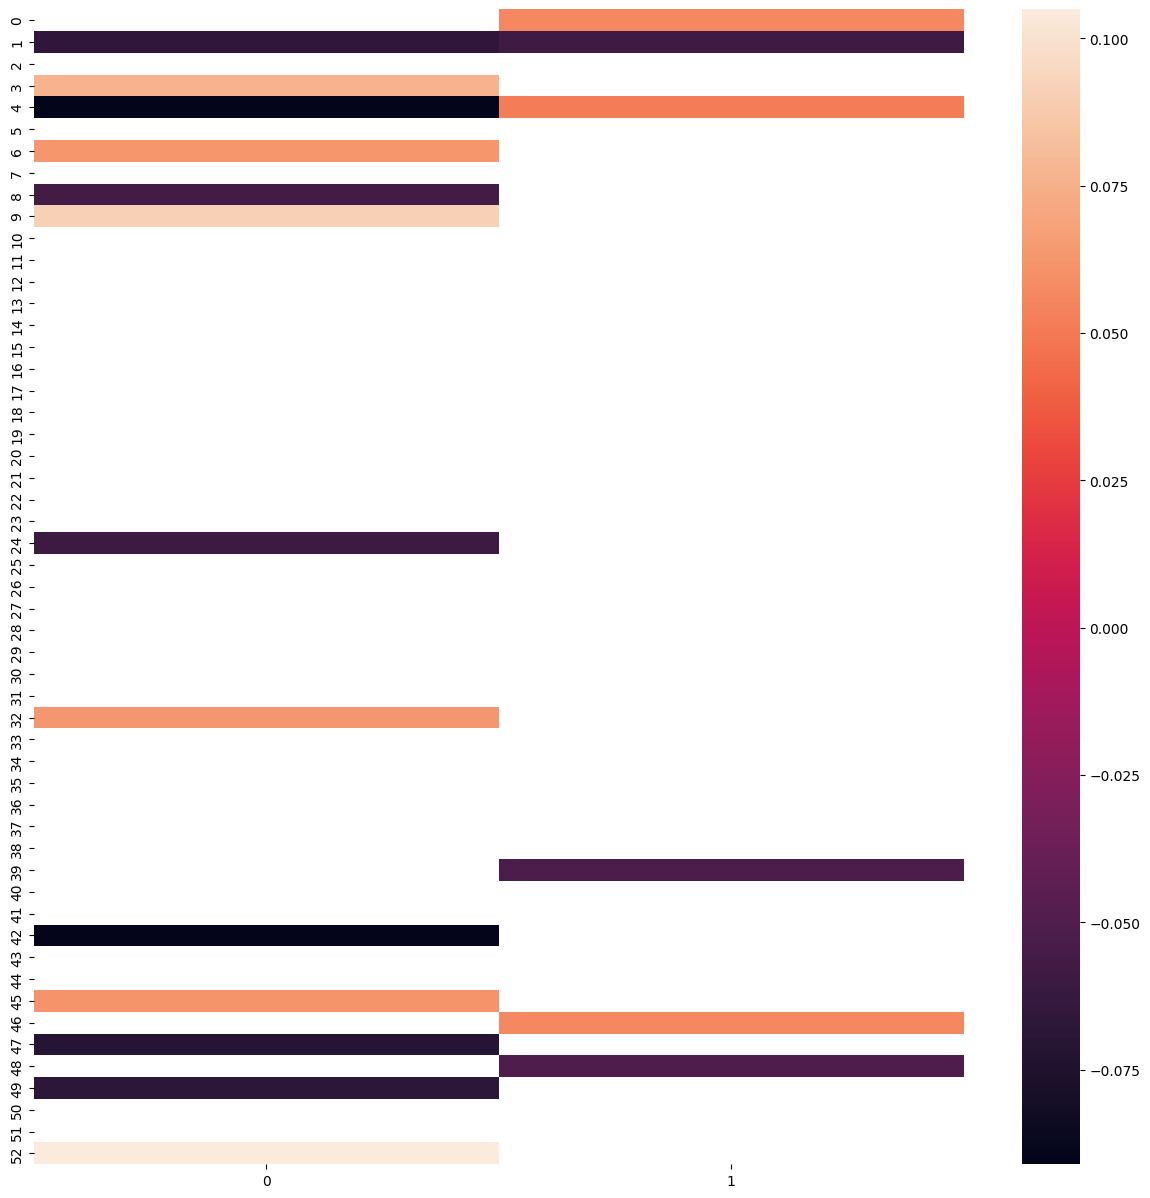

In [379]:
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn

def correlation_matrix(X_, group):
    corrected_alpha = 0.05 / (len(X_.columns)*len(group.columns))

    corr = np.zeros((X_.shape[1], group.shape[1]))
    p = np.zeros((X_.shape[1], group.shape[1]))

    for (idx1, col1), (idx2, col2) in product(enumerate(X_.T.values), enumerate(group.T.values)):
        correlation, p_val = pearsonr(col1, col2)
        corr[idx1, idx2] = correlation
        p[idx1, idx2] = p_val

    plt.figure(figsize=(15,15))
    seaborn.heatmap(corr, mask=p > corrected_alpha)
    plt.show()
correlation_matrix(X_pca, group_train)

#### Project your test data with Standard PCA, and then project it back into the original space.
• Calculate the reconstruction error for each sample.
• Look at the reconstruction error per each protected group. What do you see?


In [398]:
def reconstruction_rmse(data):
    data = scaler.transform(data[X.columns])
    data_reconstructed = pca.inverse_transform(pca.transform(data))
    rmse = ((data - data_reconstructed)**2).sum(axis=1).mean()**0.5
    return rmse
groups = pd.concat([X_test, group_test], axis=1).groupby(group_test.columns.to_list())
display(f'{reconstruction_rmse(X_test) = }', groups.apply(reconstruction_rmse).rename('reconstruction_RMSE'))

'reconstruction_rmse(X_test) = 0.24509474030380132'

SEX  RAC1P
1    1        0.248911
     2        0.271248
2    1        0.244437
     2        0.149675
Name: reconstruction_RMSE, dtype: float64

#### 3. Implement Fair PCA (refer to Lecture 7 Exercises).
• Do not forget to normalise data before applying Fair PCA.
• Use Ncomponents = Nfeatures − Nprotected groups, you have 4 protected groups).
• Look at the correlations between the new dimensions and original protected features. How
does results compare to the Standard PCA?


C:\Users\Christoffer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Christoffer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


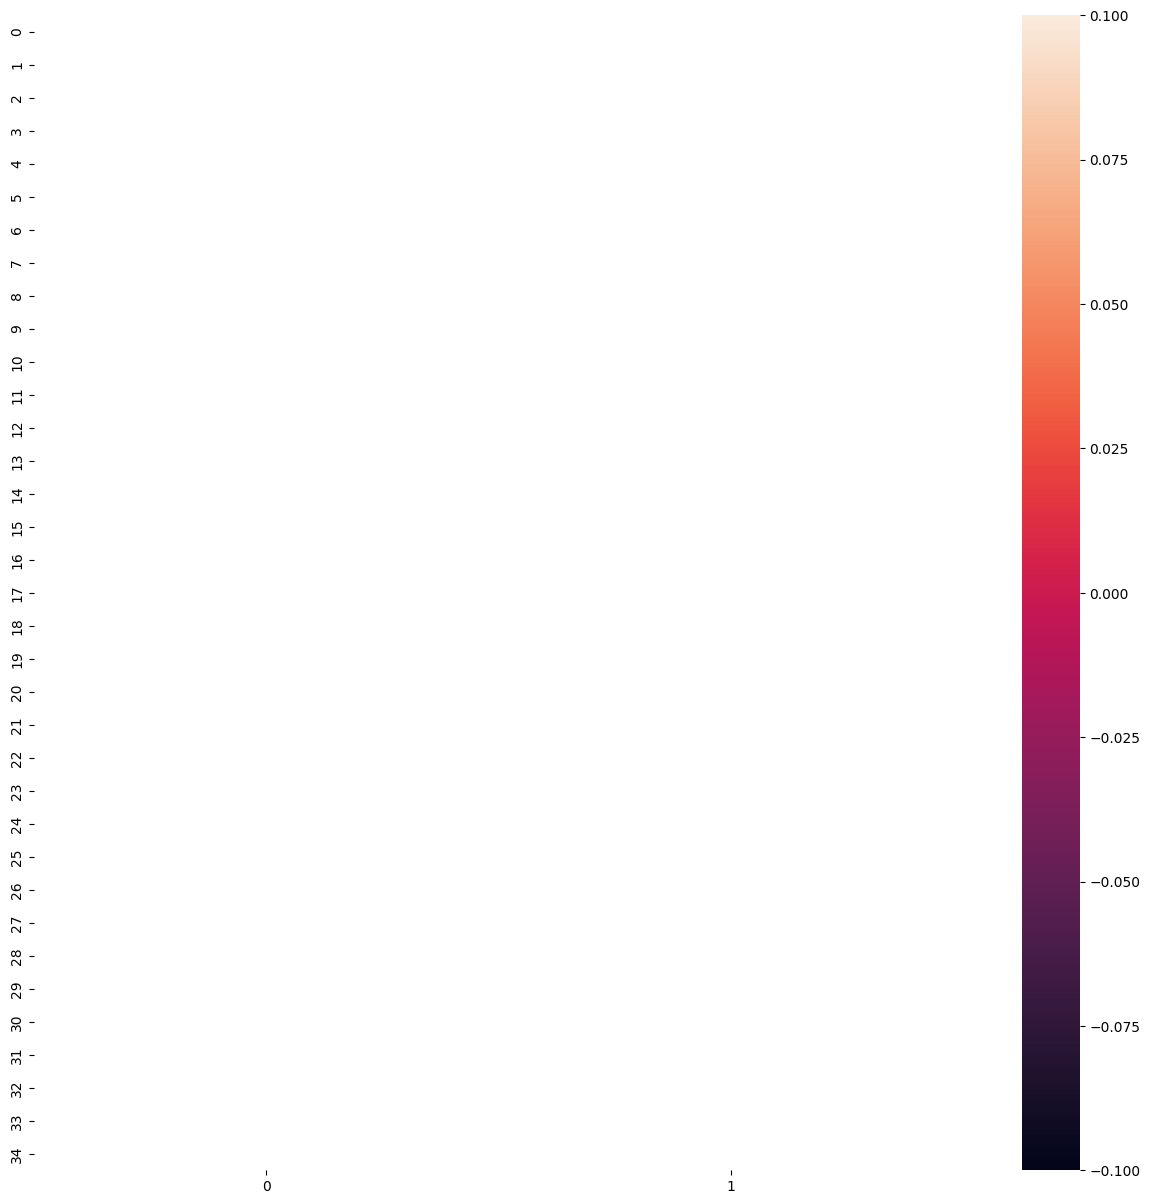

In [387]:
from scipy.linalg import null_space, eig, inv

Z = group_train
R = null_space(Z.T @ X)
Λ = R.T@X.T@X@R
eigenvals, L = eig(Λ)
U = R@L[:, :-20]
X_fair = X@U

correlation_matrix(X_fair, group_train)

#### 4. Project your test data with Fair PCA, and then project it back into the original space.
• Calculate the reconstruction error for each sample.
• Look at the reconstruction error per each protected group. What do you see? Are there any
differences compared to the Standard PCA?

In [419]:
def RMSE(error):
    return error.values.mean()**0.5

X_fair = X@U
reconstruction = X_fair @ U.T
cost = ((reconstruction.values - X)**2)
overall_cost = RMSE(cost)

groups = pd.concat([X_test, group_test], axis=1).groupby(group_test.columns.to_list())

display(f'{reconstruction_rmse(X_test) = }', groups.apply(lambda x: RMSE(x)).rename('Reconstruction RMSE'))

'reconstruction_rmse(X_test) = 0.24509474030380132'

SEX  RAC1P
1    1        1.793978
     2        1.887433
2    1        1.755967
     2        1.956534
Name: Reconstruction RMSE, dtype: float64

In [423]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, reconstruction)

0.3682037297335374